In [ ]:
"""
Predict generation of the second PV inverter (INV2) with help of the ideal sine waveform.
Frequency: Calculated with a FFT and the actual times for sunrise / sunset
Amplitude: Calculated by the max of the previous day --> scaling for the sine
Zero Phases: (t < sunrise) and (t > sunset) != 0
"""

In [2]:
# Imports
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../toolkit')
from imports import *

print(sys.path)

['x:\\git\\LRZ\\masters-thesis\\prediction\\sine', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310', '', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin', '../', '../../', '../', '../../', '../../toolkit']


+---------------------+-------------------------------------------------+
|        Field        |                      Value                      |
+---------------------+-------------------------------------------------+
|          IP         |                 100.113.141.113                 |
|      Reachable      |                       True                      |
|       Devices       |             ['INV2', 'TEMP', 'HUM']             |
|      Time (abs)     | 2024-11-25T00:00:00Z < t < 2024-11-25T23:59:00Z |
|      Time (rel)     |                       None                      |
|      Time (res)     |                        1m                       |
| Prediction horizont |                      15min                      |
|      Delimiter      |                        ;                        |
|         CWD         |    x:\git\LRZ\masters-thesis\prediction\sine    |
|     Backend Port    |                       5000                      |
|     Backend Path    |               

<AxesSubplot: xlabel='Date'>

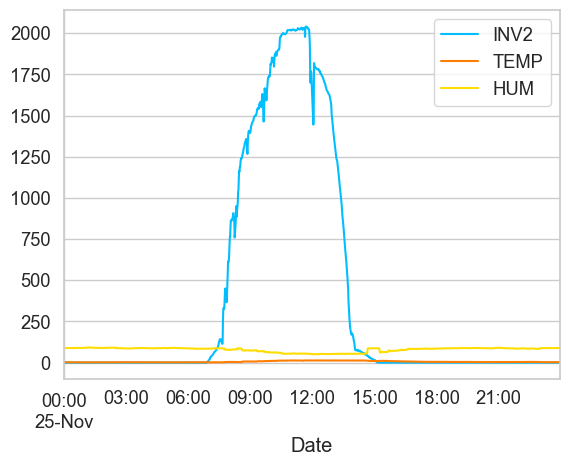

In [12]:
# Specify the IoT Server interface --> only working within the Tailscale VPN connection
ip = "100.113.141.113"
devices = ["INV2", "TEMP", "HUM"] # First device defines the value to be forecasted
# time_abs_start = "2024-06-18T00:00:00Z"
# time_abs_end   = "2024-06-19T00:00:00Z"
# time_abs_start = "2024-08-24T00:00:00Z"
# time_abs_end   = "2024-08-25T00:00:00Z"

prev_time_abs_start = "2024-11-25T00:00:00Z"
prev_time_abs_end   = "2024-11-25T23:59:00Z"
act_time_abs_start  = "2024-11-25T00:00:00Z"
act_time_abs_end    = "2024-11-25T23:59:00Z"
time_range = "None"
res = "1m"

# Day before --> basis for prediction
prev_iot_server = IotGrabber(
                          ip=ip,
                          devices=devices,
                          time_abs_start=prev_time_abs_start,
                          time_abs_end=prev_time_abs_end,
                          range=time_range,
                          res=res,
                          delimiter=";",
                          cwd=os.getcwd()
                          )

print(prev_iot_server)
prev_df = prev_iot_server.get_df()
# prev_df.plot()

tum_lat  = 48.267410
tum_long = 11.668265


sine_fitting = SineFitting(
    date=prev_time_abs_start, 
    latitude=tum_lat, 
    longitude=tum_long,
    previous_df=prev_df )
sine_fitting.set_previous_day(prev_df)

INV2_modeled = sine_fitting.calc_sine()
# dINV2 = sine_fitting.calc_d()



# Actual day
act_iot_server = IotGrabber(
                          ip=ip,
                          devices=devices,
                          time_abs_start=act_time_abs_start,
                          time_abs_end=act_time_abs_end,
                          range=time_range,
                          res=res,
                          delimiter=";",
                          cwd=os.getcwd()
                          )

print(act_iot_server)
act_df = act_iot_server.get_df()

act_df.plot()



RMSE: 400.1924807654963
                    Date  INV2  Sine  dINV2
0    2024-11-25 00:00:00   0.0   0.0    0.0
1    2024-11-25 00:01:00   0.0   0.0    0.0
2    2024-11-25 00:02:00   0.0   0.0    0.0
3    2024-11-25 00:03:00   0.0   0.0    0.0
4    2024-11-25 00:04:00   0.0   0.0    0.0
...                  ...   ...   ...    ...
1434 2024-11-25 23:54:00   0.0   0.0    0.0
1435 2024-11-25 23:55:00   0.0   0.0    0.0
1436 2024-11-25 23:56:00   0.0   0.0    0.0
1437 2024-11-25 23:57:00   0.0   0.0    0.0
1438 2024-11-25 23:58:00   0.0   0.0    0.0

[1439 rows x 4 columns]


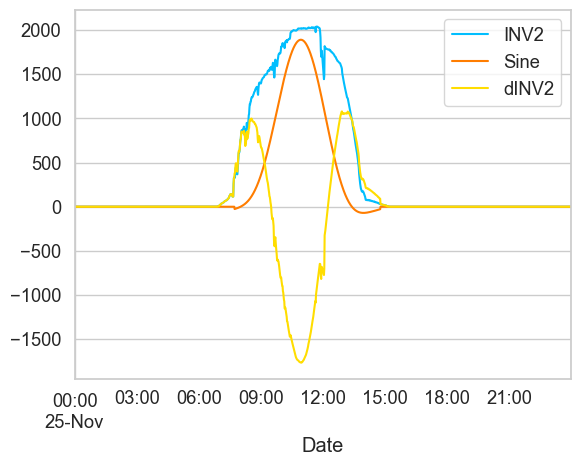

In [ ]:
# Calculate absolute deviation between the real values and the sine prediction from the day before
dPredicitionWithSine = act_df.INV2.values - INV2_modeled

# Sum everything in a pandas df
df_computed = pd.DataFrame()
df_computed.insert(0, "Date", act_df.index.values)
df_computed.insert(1, "INV2", act_df.INV2.values)
df_computed.insert(2, "Sine", INV2_modeled)
df_computed.insert(3, "dINV2", dPredicitionWithSine)
df_computed.set_index("Date")
df_computed.to_csv("sine-fitted.csv", sep=";")

# Calc RMSE value
rmse_sine = calc_rmse(df_computed.INV2, df_computed.Sine)

# Plot
df_computed.plot(x=0)
print(f"RMSE: {rmse_sine}")
with open("rmse-calc.txt", "w+") as f:
    f.write(f"{rmse_sine}")
print(df_computed)

In [21]:
# Load all csv files with predictions again

summed_df = pd.DataFrame()

for file in os.listdir():
        if file.endswith(".csv"):
                date = file.split("-")[0]
                df = pd.DataFrame()
                df = pd.read_csv(file, sep=";")

                # Add date string to cols
                df.columns = df.columns.str.replace("Date", f"{date}-Date")
                df.columns = df.columns.str.replace("INV2", f"{date}-INV2")
                df.columns = df.columns.str.replace("Sine", f"{date}-Sine")
                df.columns = df.columns.str.replace("dINV2", f"{date}-dINV2")

                print(df)
                summed_df = pd.concat([summed_df, df], axis=1)
                # summed_df.append
                # del(df)

summed_df.to_csv("prediction-with-sine-summed.csv", sep=";")

      Unnamed: 0        20240822-Date  20240822-INV2  20240822-Sine  \
0              0  2024-08-22 00:00:00            0.0            0.0   
1              1  2024-08-22 00:01:00            0.0            0.0   
2              2  2024-08-22 00:02:00            0.0            0.0   
3              3  2024-08-22 00:03:00            0.0            0.0   
4              4  2024-08-22 00:04:00            0.0            0.0   
...          ...                  ...            ...            ...   
1435        1435  2024-08-22 23:55:00            0.0            0.0   
1436        1436  2024-08-22 23:56:00            0.0            0.0   
1437        1437  2024-08-22 23:57:00            0.0            0.0   
1438        1438  2024-08-22 23:58:00            0.0            0.0   
1439        1439  2024-08-22 23:59:00            0.0            0.0   

      d20240822-INV2  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...      

In [5]:
summed_df

,Unnamed: 0,20240822-Date,20240822-INV2,20240822-Sine,d20240822-INV2,Unnamed: 0,20240823-Date,20240823-INV2,20240823-Sine,d20240823-INV2,...,20240824-summed-summed-summed-summed-Date,20240824-summed-summed-summed-summed-INV2,20240824-summed-summed-summed-summed-Sine,d20240824-summed-summed-summed-summed-INV2,Unnamed: 0.3,20240825-summed-summed-summed-summed-Date,20240825-summed-summed-summed-summed-INV2,20240825-summed-summed-summed-summed-Sine,d20240825-summed-summed-summed-summed-INV2,Unnamed: 0.4
0,0,2024-08-22 00:00:00,0.0,0.0,0.0,0,2024-08-23 00:00:00,0.0,0.0,0.0,...,2024-08-24 00:00:00,0.0,0.0,0.0,0,2024-08-25 00:00:00,0.0,0.0,0.0,NaN
1,1,2024-08-22 00:01:00,0.0,0.0,0.0,1,2024-08-23 00:01:00,0.0,0.0,0.0,...,2024-08-24 00:01:00,0.0,0.0,0.0,1,2024-08-25 00:01:00,0.0,0.0,0.0,NaN
2,2,2024-08-22 00:02:00,0.0,0.0,0.0,2,2024-08-23 00:02:00,0.0,0.0,0.0,...,2024-08-24 00:02:00,0.0,0.0,0.0,2,2024-08-25 00:02:00,0.0,0.0,0.0,NaN
3,3,2024-08-22 00:03:00,0.0,0.0,0.0,3,2024-08-23 00:03:00,0.0,0.0,0.0,...,2024-08-24 00:03:00,0.0,0.0,0.0,3,2024-08-25 00:03:00,0.0,0.0,0.0,NaN
4,4,2024-08-22 00:04:00,0.0,0.0,0.0,4,2024-08-23 00:04:00,0.0,0.0,0.0,...,2024-08-24 00:04:00,0.0,0.0,0.0,4,2024-08-25 00:04:00,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1435,2024-08-22 23:55:00,0.0,0.0,0.0,1435,2024-08-23 23:55:00,0.0,0.0,0.0,...,2024-08-24 23:55:00,0.0,0.0,0.0,1435,2024-08-25 23:55:00,0.0,0.0,0.0,NaN
1436,1436,2024-08-22 23:56:00,0.0,0.0,0.0,1436,2024-08-23 23:56:00,0.0,0.0,0.0,...,2024-08-24 23:56:00,0.0,0.0,0.0,1436,2024-08-25 23:56:00,0.0,0.0,0.0,NaN
1437,1437,2024-08-22 23:57:00,0.0,0.0,0.0,1437,2024-08-23 23:57:00,0.0,0.0,0.0,...,2024-08-24 23:57:00,0.0,0.0,0.0,1437,2024-08-25 23:57:00,0.0,0.0,0.0,NaN
1438,1438,2024-08-22 23:58:00,0.0,0.0,0.0,1438,2024-08-23 23:58:00,0.0,0.0,0.0,...,2024-08-24 23:58:00,0.0,0.0,0.0,1438,2024-08-25 23:58:00,0.0,0.0,0.0,NaN
